## Немного безумия

смотрим, работают ли attention models и другие модели

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy
import root_numpy
# import pandas - no pandas today 
from astropy.table import Table
from sklearn.metrics import roc_auc_score
from scipy.special import logit
from decisiontrain import DecisionTrainClassifier
from collections import OrderedDict

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# theano imports
import theano
from theano import tensor as T
from theano.tensor.nnet import softplus
from theano.tensor.extra_ops import bincount

In [4]:
import sys
sys.path.insert(0, '../')
from folding_group import FoldingGroupClassifier

In [5]:
features = [
    # track itself
    'eta', 'partPt', 'partP',
    # track and B
    'cos_diff_phi', 'proj', 'diff_eta', 'ptB', 'R_separation', 'proj_T', 'proj_T2',
    # PID
    'PIDNNe',  'PIDNNk',  'PIDNNm', 'ghostProb', 
    # IP
    'IP', 'IPerr', 'IPs', 'IPPU', 
    # Other
    'veloch', 'partlcs', 'EOverP', 
    # deleted as probably inappropriate:
    # 'phi',  
    # 'diff_pt', 'nnkrec',
    # 'max_PID_mu_e', 'max_PID_mu_k', 'sum_PID_k_e', 'sum_PID_mu_e', 'max_PID_k_e', 'sum_PID_mu_k', 
]

In [6]:
data = Table(root_numpy.root2array('./Bcharged_MC.root', stop=20000000))

def preprocess(data):
    data['label'] = (data['signB'] * data['signTrack']) > 0

    data['cos_diff_phi'] = numpy.cos(data['diff_phi'])
    data['diff_pt'] = data['ptB'] - data['partPt']
    data['R_separation'] = numpy.sqrt(data['diff_eta'] ** 2 + (1 - data['cos_diff_phi']) ** 2)
    # projection in transverse plane
    data['proj_T'] = data['cos_diff_phi'] * data['partPt']
    data['proj_T2'] = data['cos_diff_phi'] * data['partPt'] * data['ptB']

    data = data[data['ghostProb'] < 0.4]
    data = data[numpy.isfinite(data['IPs'])]
    
    data.rename_column('N_sig_sw', 'sweight')
    # for real data, weight is also added
    data = data[features + ['event_id', 'label', 'signTrack', 'signB', 'sweight']]

In [7]:
preprocess(data)

In [8]:
_, data['event_id'] = numpy.unique(data['event_id'], return_inverse=True)

In [9]:
N = 10 * 10 ** 6
check_data = data[N:].copy()
data = data[:N].copy()
_, check_data['event_id'] = numpy.unique(check_data['event_id'], return_inverse=True)
_, data['event_id'] = numpy.unique(data['event_id'], return_inverse=True)

## Вспомогательные функции

In [10]:
def compute_weights(data, attention):
    """
    Weights are normalized over events. Higher convenience - higher weights
    """
    assert len(numpy.shape(attention)) == 1
    weights = numpy.exp(attention)
    sum_weights = numpy.bincount(data['event_id'], weights=weights)
    return weights / (sum_weights[data['event_id']] + 1)

In [11]:
def compute_simple_auc(data, track_proba):
    assert track_proba.shape == (len(data), 2)
    event_predictions = numpy.bincount(
        data['event_id'], weights=logit(track_proba[:, 1]) * data['signTrack'])
    B_signs = data['signB'].group_by(data['event_id']).groups.aggregate(numpy.mean)
    return roc_auc_score(B_signs, event_predictions)

In [12]:
def compute_auc_with_attention(data, track_proba, track_attention):
    assert track_proba.shape == (len(data), 2)
    assert len(track_attention) == len(data)
    tracks_weights = compute_weights(data, track_attention)
    event_predictions = numpy.bincount(
        data['event_id'], weights=logit(track_proba[:, 1]) * data['signTrack'] * tracks_weights)
    B_signs = data['signB'].group_by(data['event_id']).groups.aggregate(numpy.mean)
    return roc_auc_score(B_signs, event_predictions)

## Графики

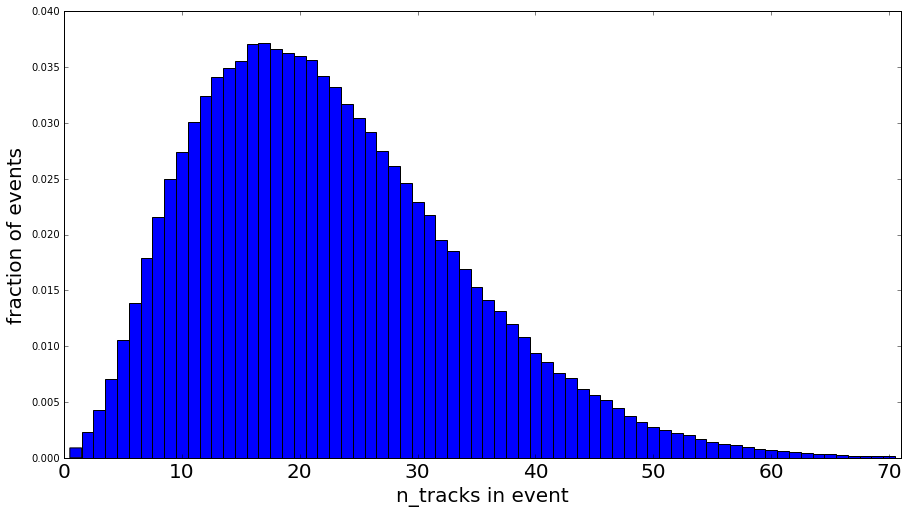

In [13]:
plt.figure(figsize=[15, 8])
plt.hist(numpy.bincount(data['event_id']), range=[0.5, 70.5], bins=70, normed=True);
plt.xlim(0, 71)
plt.xlabel('n_tracks in event', fontsize=20)
plt.ylabel('fraction of events', fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('./n_tracks.png', bbox_inches='tight')

In [14]:
base_clf = DecisionTrainClassifier(n_estimators=1000, learning_rate=0.03, n_threads=len(features), 
                                   train_features=features, max_features=0.9)

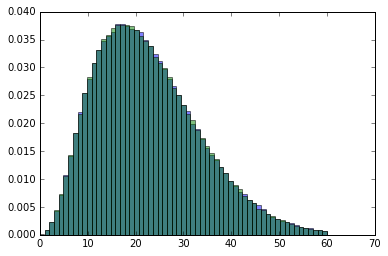

In [15]:
plt.hist(numpy.bincount(data['event_id']),       bins=61, range=(0, 60), alpha=0.5, normed=True)
plt.hist(numpy.bincount(check_data['event_id']), bins=61, range=(0, 60), alpha=0.5, normed=True);

## Просто поезд + inclusive

In [17]:
%%time
dt = FoldingGroupClassifier(base_clf, n_folds=3, group_feature='event_id')
_ = dt.fit(data[features + ['event_id']].to_pandas(), data['label'])

CPU times: user 5min 9s, sys: 1.66 s, total: 5min 10s
Wall time: 25.8 s


In [18]:
# raw quality
print compute_simple_auc(check_data, dt.predict_proba(check_data.to_pandas()))
print compute_auc_with_attention(check_data, 
                                 track_proba=dt.predict_proba(check_data.to_pandas()), 
                                 track_attention=numpy.zeros(len(check_data)))

KFold prediction using folds column
0.651924189255
KFold prediction using folds column
0.653847054211


In [19]:
# raw quality
print compute_simple_auc(data, dt.predict_proba(data.to_pandas()))
print compute_auc_with_attention(data, 
                                 track_proba=dt.predict_proba(data.to_pandas()), 
                                 track_attention=numpy.zeros(len(data)))

KFold prediction using folds column
0.646931502007
KFold prediction using folds column
0.647874211783


## Для сравнения 
фильтрация выборки


In [22]:
%%time
_n_tracks = numpy.bincount(data['event_id'])[data['event_id']] 
_weights = (_n_tracks > 5) & (_n_tracks < 40)
dt_on_filtered = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
_ = dt_on_filtered.fit(data[features + ['event_id']].to_pandas(), data['label'], sample_weight=_weights)

CPU times: user 2min 40s, sys: 740 ms, total: 2min 41s
Wall time: 14.3 s


In [23]:
# on filtered dataset
compute_auc_with_attention(data, 
                           track_proba=dt_on_filtered.predict_proba(data.to_pandas()),
                           track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column


0.64700106269601321

In [24]:
sorted(zip(dt.estimators[0].feature_importances_ + dt.estimators[1].feature_importances_, features))

[(0.050000000000000003, 'eta'),
 (0.051000000000000004, 'EOverP'),
 (0.052999999999999999, 'proj_T'),
 (0.057999999999999996, 'diff_eta'),
 (0.064000000000000001, 'proj_T2'),
 (0.069000000000000006, 'cos_diff_phi'),
 (0.069000000000000006, 'ghostProb'),
 (0.070000000000000007, 'partlcs'),
 (0.078, 'ptB'),
 (0.079000000000000001, 'veloch'),
 (0.084999999999999992, 'PIDNNe'),
 (0.085999999999999993, 'PIDNNm'),
 (0.088999999999999996, 'IPPU'),
 (0.089999999999999997, 'IPerr'),
 (0.095000000000000001, 'partP'),
 (0.11799999999999999, 'R_separation'),
 (0.14100000000000001, 'proj'),
 (0.14200000000000002, 'IPs'),
 (0.14700000000000002, 'IP'),
 (0.16699999999999998, 'partPt'),
 (0.19900000000000001, 'PIDNNk')]

# Длинный поезд

In [25]:
long_dt = FoldingGroupClassifier(
    DecisionTrainClassifier(n_estimators=3000, learning_rate=0.02, max_features=0.9,
                            n_threads=len(features), train_features=features), 
    n_folds=2, group_feature='event_id')

In [26]:
_ = long_dt.fit(data[features + ['event_id']].to_pandas(), 
                data['label'], 
                sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2.))

In [27]:
for i, p in enumerate(long_dt.staged_predict_proba(data.to_pandas()), 1):
    if i % 5 == 0:
        print compute_auc_with_attention(data, track_proba=p, track_attention=numpy.zeros(len(data)) - 2.)

KFold prediction using folds column
0.631652977748
0.647946838244
0.649782143503
0.648995171714
0.646874241027
0.643770485125


## Если просто взвесить обучающую выборку

то есть отнормировать веса треков внутри одного события, получаем существенный прирост, если их использовать во время предсказания.

При этом использование весов в тренировке - это странно. При малом числе событий работает, при большом - нет

In [28]:
weights = compute_weights(data, attention=numpy.zeros(len(data)))

In [29]:
dt_simpleweights = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
dt_simpleweights.fit(data[features + ['event_id']].to_pandas(), data['label'], sample_weight=weights);

In [30]:
compute_auc_with_attention(data, 
                           track_proba=dt_simpleweights.predict_proba(data.to_pandas()), 
                           track_attention=numpy.zeros(len(data)))

KFold prediction using folds column


0.64851601405840786

## Посмотрим на качество в зависимости от числа треков

In [31]:
n_tracks = numpy.bincount(data['event_id'])

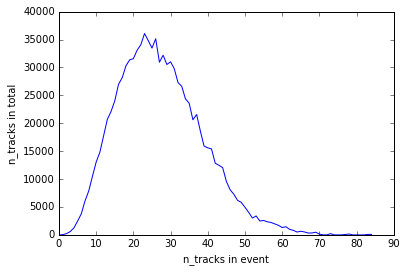

In [32]:
plt.plot(numpy.bincount(n_tracks) * numpy.arange(max(n_tracks) + 1))
plt.xlabel('n_tracks in event')
plt.ylabel('n_tracks in total')

In [33]:
# plt.plot(* zip(*(
#         [i, roc_auc_score(B_signs[n_tracks == i], predictions[n_tracks == i])]
#         for i in range(2, 60)
# )))

# Попытаемся отличить правильно предсказанные.

In [75]:
# correctness = logit(dt.predict_proba(data.to_pandas())[:, 1]) * (2 * data['label'] - 1)

In [74]:
# for percentile in [50, 60, 70, 80]:
#     dt_attention = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
#     dt_attention.fit(data[features + ['event_id']].to_pandas(), 
#                      correctness > numpy.percentile(correctness, percentile))

#     attention = logit(dt_attention.predict_proba(data[features + ['event_id']].to_pandas())[:, 1])
#     if percentile == 70:
#         stable_attention = attention.copy()
#     attention_weights = compute_weights(data, attention)

#     dt_classifier = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
#     dt_classifier.fit(data[features + ['event_id']].to_pandas(), 
#                       data['label'], sample_weight=attention_weights)

#     print percentile, compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), attention)

## Дополнительная проверка верности корректировки веса
пробуем, работает ли линейная корректировка веса.

Да, при этом сдвиг является важным, то есть наличие нормализации порядка $e^2$

In [16]:
_proba = dt.predict_proba(data.to_pandas())
for alpha in [-3, -2, -1, 0]:
    for beta in numpy.linspace(0.5, 1.2, 5):
        print alpha, '\t', beta, '\t', compute_auc_with_attention(data, _proba, alpha + beta * stable_attention)

NameError: name 'dt' is not defined

## Attention (пошла в презентацию)
того, что взаимное обучение attention и классификатора работает. 


In [18]:
def train_on_data(data):
    # lazy start
    _attention = numpy.zeros(len(data))
    _correctness = numpy.zeros(len(data))

    for iteration in range(3):
        dt_classifier = FoldingGroupClassifier(base_clf, n_folds=3, group_feature='event_id', random_state=iteration * 10)
        dt_classifier.fit(data[features + ['event_id']].to_pandas(),
                          data['label'], sample_weight=compute_weights(data, _attention))

        _correctness = logit(dt_classifier.predict_proba(data.to_pandas())[:, 1]) * (2 * data['label'] - 1)

        # print compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)

        dt_attention = FoldingGroupClassifier(base_clf, n_folds=3, group_feature='event_id', random_state=3 + iteration * 1222)
        dt_attention.fit(data[features + ['event_id']].to_pandas(),
                         _correctness > numpy.percentile(_correctness, 70))

        _attention = logit(dt_attention.predict_proba(data.to_pandas())[:, 1])
        print compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)
    return dt_classifier, dt_attention

In [20]:
models = {}
assert len(data) >= 10 * 10 ** 6
for train_size in [100000, 300000, 10 ** 6, 3 * 10 ** 6, 10 ** 7]: # , 1000000, 3000000
    models[train_size] = train_on_data(data[:train_size])

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.610127835082
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.62152978986
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.622016675527
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.641029651969
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.64440339704
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.643039992384
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.65425724553
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.654431302348
KFold prediction us

In [19]:
models_simple_dt = OrderedDict()
for train_size in [100000, 300000, 10 ** 6, 3 * 10 ** 6, 10 ** 7]: # , 1000000, 3000000
    _dt = FoldingGroupClassifier(base_clf, n_folds=3, group_feature='event_id')
    _dt.fit(data[features + ['event_id']][:train_size].to_pandas(), data['label'][:train_size])
    models_simple_dt[train_size] = _dt

In [28]:
# import cPickle
# with open('./attention_models.pkl', 'w') as f:
#     cPickle.dump([models, models_simple_dt], f, protocol=2)

In [264]:
import cPickle
with open('./attention_models.pkl', 'r') as f:
    models, models_simple_dt = cPickle.load(f)

In [272]:
def compute_auc_with_attention_and_error(data, track_proba, track_attention):
    assert track_proba.shape == (len(data), 2)
    assert len(track_attention) == len(data)
    tracks_weights = compute_weights(data, track_attention)
    event_predictions = numpy.bincount(
        data['event_id'], weights=logit(track_proba[:, 1]) * data['signTrack'] * tracks_weights)
    B_signs = data['signB'].group_by(data['event_id']).groups.aggregate(numpy.mean)
    values = []
    
    for i in range(20):
        mask = numpy.random.RandomState(i).uniform(size=len(B_signs)) > 0.5
        values.append(roc_auc_score(B_signs[mask], event_predictions[mask]))
        
    return numpy.mean(values), numpy.std(values)

In [279]:
attention_aucs = OrderedDict()
for size, (dt_classifier, dt_attention) in sorted(models.iteritems()):
    attention_aucs[size] = compute_auc_with_attention_and_error(
        check_data, 
        dt_classifier.predict_proba(check_data.to_pandas()), 
        logit(dt_attention.predict_proba(check_data.to_pandas())[:, 1]) 
    )

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column


In [273]:
dt_aucs = OrderedDict()
for size, _dt_classifier in sorted(models_simple_dt.iteritems()):
    dt_aucs[size] = compute_auc_with_attention_and_error(
        check_data, 
        _dt_classifier.predict_proba(check_data.to_pandas()), 
        numpy.zeros(len(check_data))
    )

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


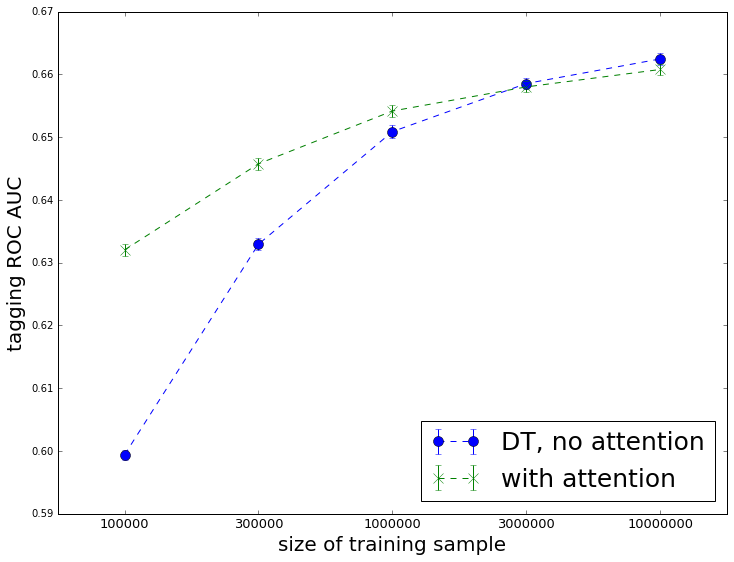

In [285]:
plt.figure(figsize=[12, 9])
x_ticks = range(len(dt_aucs))
# plt.plot(dt_aucs.values(), 'o--', label='plain DT', markersize=10)
plt.errorbar(x_ticks,
             [x for (x, _) in dt_aucs.values()], 
             yerr=[x for (_, x) in dt_aucs.values()], fmt='o--', label='DT, no attention', markersize=10)
# plt.plot(attention_aucs.values(), 'x--', label='with attention', markersize=10)
plt.errorbar(x_ticks,
             [x for (x, _) in attention_aucs.values()], 
             yerr=[x for (_, x) in attention_aucs.values()], fmt='x--', label='with attention', markersize=10)

plt.xticks(x_ticks, dt_aucs.keys(), fontsize=13)
plt.legend(loc='lower right', fontsize=25)
plt.xlabel('size of training sample', fontsize=20)
plt.ylabel('tagging ROC AUC', fontsize=20)
plt.xlim(-0.5, 4.5)
plt.savefig('./attention_quality.png', bbox_inches='tight')

In [40]:
# orders = compute_orders(data['event_id'], correctness)

In [41]:
# for percentile in [60, 70, 80]:
#     for n_tracks in [3, 5, 7]:
#         # lazy start
#         _attention = numpy.zeros(len(data))

#         dt_classifier = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
#         dt_classifier.fit(data[features + ['event_id']].to_pandas(),
#                           data['label'], sample_weight=compute_weights(data, _attention))

#         _correctness = logit(dt_classifier.predict_proba(data.to_pandas())[:, 1]) * (2 * data['label'] - 1)

#         dt_attention = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='event_id')
#         dt_attention.fit(data[features + ['event_id']].to_pandas(),
#                          (_correctness > numpy.percentile(_correctness, percentile)) * (orders < n_tracks) )

#         _attention = logit(dt_attention.predict_proba(data.to_pandas())[:, 1])

#         print n_tracks, '\t', percentile, '\t', \
#             compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)

## Небольшое сравнение importance для моделей attention и classifier

In [ ]:
# sorted(zip(dt_classifier.estimators[0].feature_importances_, features))

In [ ]:
# sorted(zip(dt_attention.estimators[0].feature_importances_, features))

# Сравнение моделей (для презентации)


In [40]:
%%time
from rep.estimators import XGBoostClassifier
n_train = 10 ** 6

xgb = FoldingGroupClassifier(XGBoostClassifier(n_estimators=100, eta=0.05, random_state=42), 
                             n_folds=2, group_feature='event_id', train_features=features, random_state=1337)
_ = xgb.fit(data[features + ['event_id']][:n_train].to_pandas(), data['label'][:n_train])

CPU times: user 23min 4s, sys: 3.07 s, total: 23min 7s
Wall time: 2min 7s


In [41]:
# raw quality 
for p in xgb.staged_predict_proba(check_data.to_pandas()):
    print compute_simple_auc(check_data, p)

KFold prediction using random classifier (length of data passed not equal to length of train)
0.638642631985
0.643473898638
0.64472352472
0.645455797349
0.645492431884
0.645047959403
0.644323441615
0.643503284718
0.64271961868
0.6416346645


In [42]:
# raw quality
# for p in xgb.staged_predict_proba(data.to_pandas()):
#     print compute_simple_auc(data, p)

In [157]:
%%time
dt_1m = FoldingGroupClassifier(
    DecisionTrainClassifier(n_estimators=1000, learning_rate=0.01, n_threads=len(features), max_features=1.0),
                            n_folds=2, group_feature='event_id', train_features=features, random_state=1337)
dt_1m.fit(data[features + ['event_id']][:n_train].to_pandas(), data['label'][:n_train]);

CPU times: user 2min 34s, sys: 1.31 s, total: 2min 35s
Wall time: 13.5 s


In [158]:
# raw quality 
for p in dt_1m.staged_predict_proba(check_data.to_pandas()):
    print compute_simple_auc(check_data, p)

KFold prediction using random classifier (length of data passed not equal to length of train)
0.595834456784
0.615225577611
0.634637995935
0.645308082353
0.650191223429
0.652475850165
0.653876383608
0.654241717205
0.654306658251
0.653900852144


### нейросетки

In [45]:
from hep_ml.nnet import MLPClassifier

In [48]:
# 0.6204 - 400
for epochs in [50, 100, 200, 400]:
    nn = FoldingGroupClassifier(MLPClassifier(layers=[30, 20], epochs=epochs, scaler='iron', random_state=42), 
                                n_folds=2, group_feature='event_id', train_features=features, random_state=1337)
    nn.fit(data[features + ['event_id']][:n_train].to_pandas(), data['label'][:n_train]);
    print compute_simple_auc(check_data, nn.predict_proba(check_data.to_pandas()))

KFold prediction using random classifier (length of data passed not equal to length of train)
0.614285319801
KFold prediction using random classifier (length of data passed not equal to length of train)
0.617953778445
KFold prediction using random classifier (length of data passed not equal to length of train)
0.619746450922
KFold prediction using random classifier (length of data passed not equal to length of train)
0.620437567331


In [ ]:
%%time
for epochs in [800]:
    nn = FoldingGroupClassifier(MLPClassifier(layers=[30, 20], epochs=epochs, scaler='iron', random_state=42), 
                                n_folds=2, group_feature='event_id', train_features=features, random_state=1337)
    nn.fit(data[features + ['event_id']][:n_train].to_pandas(), data['label'][:n_train]);
    print compute_simple_auc(check_data, nn.predict_proba(check_data.to_pandas()))

KFold prediction using random classifier (length of data passed not equal to length of train)
0.610424550577
CPU times: user 1h 29min 35s, sys: 7min 30s, total: 1h 37min 6s
Wall time: 28min 2s


In [163]:
print compute_simple_auc(data, nn.predict_proba(data.to_pandas()))

KFold prediction using random classifier (length of data passed not equal to length of train)
0.612723139429


## Для сравнения возьмем простой MLP из keras


84 sec/ iteration

In [100]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

In [154]:
print "%f" % (1e-3 / 20 )

0.000050


In [101]:
model = Sequential()
model.add(BatchNormalization(input_shape=(len(features),)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(300, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3 / 20),
              metrics=['accuracy', ])

In [102]:
# from sklearn.metrics import log_loss
def train_nn(data, check_data, n_epochs=100):
    numpy.random.seed(1337)
    _X, _y = data[features].to_pandas().values, to_categorical(data['label'])
    _check_X, _check_y = check_data[features].to_pandas().values, to_categorical(check_data['label'])
    for _ in range(n_epochs):
        history = model.fit(_X, _y, 
            nb_epoch=1, verbose=2, 
        )

        _track_proba = model.predict_proba(_check_X, verbose=2)


        histories.append(history)
        nn_evaluations_simple.append(compute_simple_auc(check_data, _track_proba))
        nn_evaluations_attention.append(compute_auc_with_attention(check_data, _track_proba, 
                                                                   numpy.zeros(len(check_data)) - 2))
        nn_evaluations_testlosses.append(log_loss(_check_y[:, 1], _track_proba))


In [ ]:
histories = []
nn_evaluations_simple = []
nn_evaluations_attention = []
nn_evaluations_testlosses = []
train_nn(data[:n_train], check_data, n_epochs=100)

126s - loss: 0.6917 - acc: 0.5170


KeyboardInterrupt: 

In [105]:
with open('./nn_history.pkl', 'w') as f:
    cPickle.dump([nn_evaluations_simple, nn_evaluations_attention, nn_evaluations_testlosses, histories], f)

In [111]:
train_losses = [h.history['loss'] for h in histories]

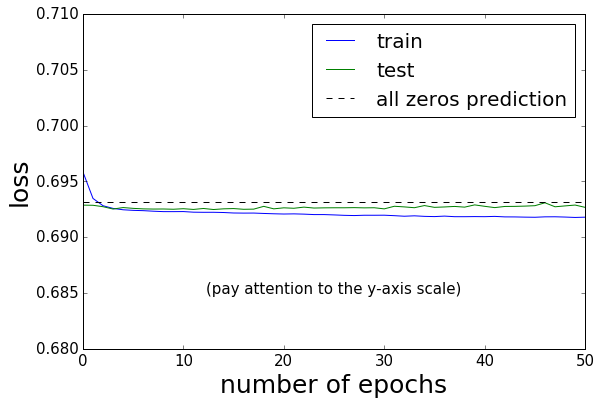

In [148]:
plt.figure(figsize=[9, 6])
plt.plot(train_losses, label='train')
plt.plot(nn_evaluations_testlosses, label='test')
plt.plot(numpy.zeros(len(nn_evaluations_simple)) + numpy.log(2), 'k--', label='all zeros prediction')
plt.xlim(0, 50)
plt.ylim(0.680, 0.710)
plt.xlabel('number of epochs', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.text(25, 0.685, '(pay attention to the y-axis scale)', horizontalalignment='center', fontsize=15)
plt.savefig('./nns_losses.png', bbox_inches='tight')

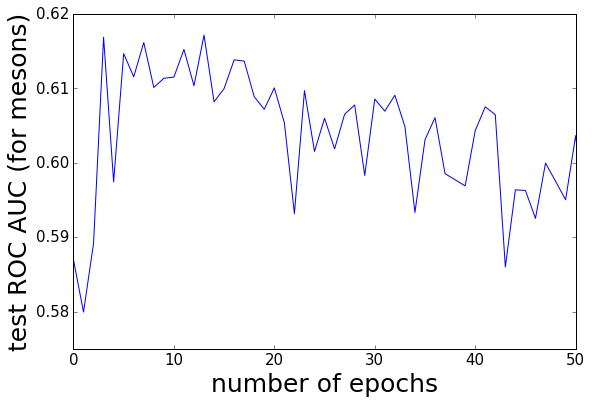

In [149]:
plt.figure(figsize=[9, 6])
plt.plot(nn_evaluations_simple)

plt.xlabel('number of epochs', fontsize=25)
plt.ylabel('test ROC AUC (for mesons)', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(0, 50)

plt.savefig('./nns_rocauc.png', bbox_inches='tight')

In [ ]:
_dt = DecisionTrainClassifier(n_estimators=1000, learning_rate=0.01, max_features=1., n_threads=len(features),
                              train_features=features)
_dt.fit(data[:10**6].to_pandas(), data['label'][:10**6])
_step = 50
_aucs = []
for p in _dt.staged_predict_proba(check_data.to_pandas(), step=_step):
    _aucs.append(compute_simple_auc(check_data, p))

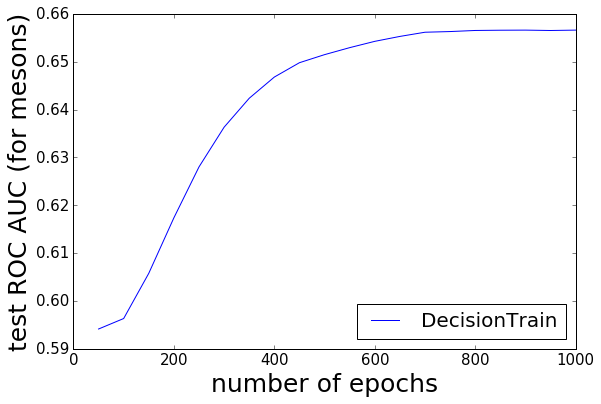

In [215]:
plt.figure(figsize=[9, 6])
plt.plot(numpy.arange(1, len(_aucs) + 1) * _step, _aucs, label='DecisionTrain')

plt.xlabel('number of epochs', fontsize=25)
plt.ylabel('test ROC AUC (for mesons)', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(0, 1000)
plt.legend(fontsize=20, loc='lower right')

plt.savefig('./dt1m_roc_history.png', bbox_inches='tight')

In [160]:
max(nn_evaluations_simple)

0.61715968509065644

### comparison of ROC AUCs

In [187]:
from sklearn.metrics.ranking import auc, roc_curve

In [245]:
import cPickle 
with open('../models/old-rocs-MC-copied', 'r') as f:
    baseline_fpr, baseline_tpr, _ = cPickle.load(f)

In [189]:
%%time
dt_10m = DecisionTrainClassifier(n_estimators=1000, learning_rate=0.03, max_features=1., n_threads=len(features),
                                 train_features=features)
dt_10m.fit(data.to_pandas(), data['label'])

CPU times: user 17min 42s, sys: 2min 49s, total: 20min 31s
Wall time: 2min 46s


In [190]:
for p in dt_10m.staged_predict_proba(check_data.to_pandas()):
    print compute_simple_auc(check_data, p)

0.612342754452
0.643616104837
0.654201817472
0.657948858835
0.659222108824
0.66016853215
0.660645284074
0.660961170161
0.661139341089
0.661262581071


In [194]:
track_proba_10m = dt_10m.predict_proba(check_data.to_pandas())
_event_predictions = numpy.bincount(check_data['event_id'], weights=logit(track_proba_10m[:, 1]) * check_data['signTrack'])
_B_signs = check_data['signB'].group_by(check_data['event_id']).groups.aggregate(numpy.mean)

In [195]:
fpr_10m, tpr_10m, _ = roc_curve(_B_signs, _event_predictions)

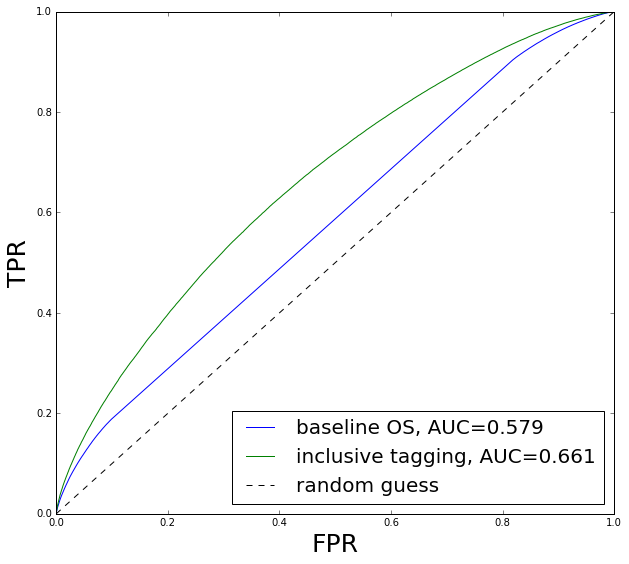

In [205]:
plt.figure(figsize=[10, 9])
plt.plot(baseline_fpr, baseline_tpr, label='baseline OS, AUC={:.3}'.format(auc(baseline_fpr, baseline_tpr)))
plt.plot(fpr_10m, tpr_10m, label='inclusive tagging, AUC={:.3f}'.format(auc(fpr_10m, tpr_10m)) )
plt.plot([0,1], [0,1], 'k--', label='random guess')
plt.xlabel('FPR', fontsize=25)
plt.ylabel('TPR', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
plt.savefig('./inclusive_vs_old_rocs.png', bbox_inches='tight')

## Реальные данные

In [217]:
real_data = Table(root_numpy.root2array('./Bcharged_data.root', stop=10000000))

In [219]:
# real_data.colnames

In [248]:
def compute_simple_auc_with_weight(data, track_proba):
    assert track_proba.shape == (len(data), 2)
    event_predictions = numpy.bincount(
        data['event_id'], weights=logit(track_proba[:, 1]) * data['signTrack'])
    B_signs = data['signB'].group_by(data['event_id']).groups.aggregate(numpy.mean)
    sweights = data['N_sig_sw'].group_by(data['event_id']).groups.aggregate(numpy.mean) 
    # TODO delete hack, this is problem in data
    sweights[B_signs != numpy.sign(B_signs)] = 0
    B_signs[B_signs != numpy.sign(B_signs)] = -1
    fpr, tpr, _ = roc_curve(B_signs, event_predictions, sample_weight=sweights)
    return roc_auc_score(B_signs, event_predictions, sample_weight=sweights), fpr, tpr

In [ ]:
_auc, _fpr_10mcheck, _tpr_10mcheck = \
    compute_simple_auc_with_weight(real_data, track_proba=dt_10m.predict_proba(real_data.to_pandas()))

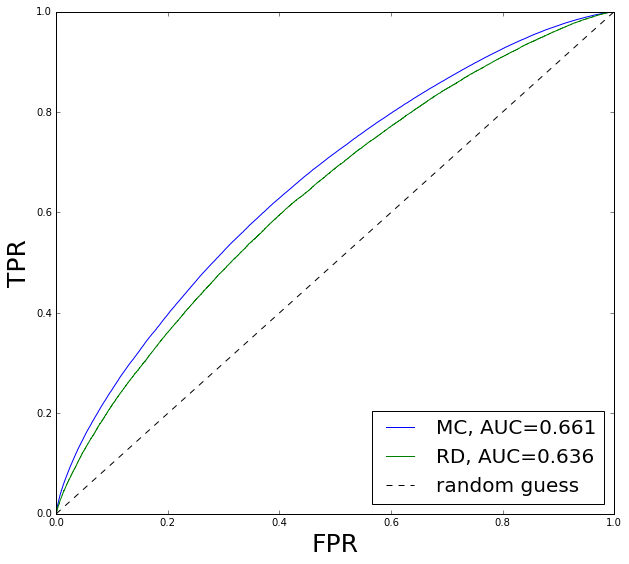

In [262]:
plt.figure(figsize=[10, 9])
plt.plot(fpr_10m, tpr_10m, label='MC, AUC={:.3}'.format(auc(fpr_10m, tpr_10m)))
plt.plot(_fpr_10mcheck, _tpr_10mcheck, label='RD, AUC={:.3f}'.format(_auc) )
plt.plot([0,1], [0,1], 'k--', label='random guess')
plt.xlabel('FPR', fontsize=25)
plt.ylabel('TPR', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
plt.xlim(0, 1.)
plt.ylim(0, 1.)
plt.savefig('./inclusive_mc_vs_rd_rocs.png', bbox_inches='tight')

In [ ]:
# for _p in dt_10m.staged_predict_proba(real_data.to_pandas()):
#     print compute_simple_auc_with_weight(real_data, _p)

In [233]:
compute_simple_auc_with_weight(check_data, dt_10m.predict_proba(check_data.to_pandas()))

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan

In [234]:
compute_simple_auc(check_data, dt_10m.predict_proba(check_data.to_pandas()))

0.66126258107053282

# Математическая модель дальнейших действий

GroupLogLoss и DropoutLoss дают прирост при всех размерах, но в презентацию не пошли

$$ d(B+) = \sum_{\text{track}} d(B+ | \text{track is tagging}) 1_\text{track is tagging} $$

In [44]:
def loss_function(b_signs, event_indices, d_tracksign, d_is_tagging):
    track_contributions = T.exp(d_is_tagging)
    track_contributions /= (T.extra_ops.bincount(event_indices, track_contributions) + 1)[event_indices]
    d_B = bincount(event_indices, d_tracksign * track_contributions)
    return T.mean(T.exp(- b_signs * d_B))
    # return T.mean(b_signs * d_B)

In [45]:
from sklearn.base import BaseEstimator
class AttentionLoss(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, sample_weight=None):
        # self.sample_weight = numpy.require(sample_weight, dtype='float32')
        self.sample_weight = numpy.ones(len(X))
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, event_indices = numpy.unique(X['event_id'].values, return_index=True, return_inverse=True)
        self.b_signs = numpy.array(X['signB'].values)[first_positions]
        
        d_is_tagging_var = T.vector()
        self.Loss = loss_function(
            self.b_signs, event_indices, 
            d_tracksign=numpy.array(X['trackpredictions'].values),
            d_is_tagging=d_is_tagging_var
        )
        self.grad = theano.function([d_is_tagging_var], - T.grad(self.Loss, d_is_tagging_var))
        
        return self

    def prepare_tree_params(self, pred):
        _grad = numpy.sign(self.grad(pred))
        return _grad / numpy.std(_grad), self.sample_weight

In [46]:
data2 = data.copy()
data2['trackpredictions'] = logit(dt.predict_proba(data.to_pandas())[:, 1])

KFold prediction using folds column


In [47]:
# _base = DecisionTrainClassifier(loss=AttentionLoss(), n_estimators=1000, 
#                                 learning_rate=0.03, n_threads=16, train_features=features)

# _features = features + ['event_id', 'signB', 'trackpredictions']
# dt_grouping = FoldingGroupClassifier(_base, n_folds=2, group_feature='event_id', train_features=_features)

# dt_grouping.fit(data2[_features].to_pandas(), 
#                 data2['label']);

In [48]:
# attention = logit(dt_grouping.predict_proba(data2.to_pandas())[:, 1])

In [49]:
from rep.metaml import FoldingRegressor
from decisiontrain import DecisionTrainRegressor

In [50]:
simple_weights = compute_weights(data, attention=numpy.zeros(len(data)))

In [51]:
# Пробуем тренировку на перцентиль. Пока что самый стабильный вариант
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), correctness > numpy.percentile(correctness, 70), sample_weight=simple_weights);

In [52]:
# Тренировка на корректность работает плохо
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), correctness / numpy.std(correctness), sample_weight=simple_weights);

In [53]:
# Пробуем тренировку на порядок. Лучше, чем ничего, хуже, чем перцентиль
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), 1.4 ** - orders, sample_weight=simple_weights);

In [54]:
# Пробуем тренировку на ranktransform от 
folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
folding.fit(data2[features].to_pandas(), 
            numpy.argsort(numpy.argsort(correctness)) / float(len(correctness)) - 0.5, 
            sample_weight=simple_weights);

In [55]:
# Пробуем тренировку на знак
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), numpy.sign(correctness), sample_weight=simple_weights);

In [56]:
# _correctness

In [57]:
attention = folding.predict(data2.to_pandas())

KFold prediction using folds column


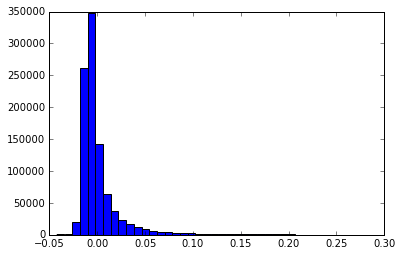

In [58]:
plt.hist(attention, bins=40);

In [59]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), 
                           track_attention=attention - 1.5
                           )

KFold prediction using folds column


0.64957212893434657

In [60]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), 
                           track_attention=compute_weights(data, attention) - 2
                           )

KFold prediction using folds column


0.64888997319992037

In [61]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), track_attention=attention * 0 - 3)

KFold prediction using folds column


0.64906882552382728

In [62]:
compute_auc_with_attention(data[:10**6], 
                           track_proba=dt.predict_proba(data2.to_pandas())[:10 ** 6], 
                           track_attention=attention[:10 ** 6] * 0 - 3)

KFold prediction using folds column


0.64906882552382728

# Идея: dropout_loss

лосс-функция по типу exploss для тренировки обычного классификатора.

- оптимальным всегда оказывался вариант с p=0 
    - на 3 миллионах выиграл у всего остального
- назначение весов (равномерных) почему-то не такое, как везде

In [63]:
from sklearn.base import BaseEstimator
class DropoutLoss(BaseEstimator):
    def __init__(self, p=0.0):
        self.p = p

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = numpy.require(sample_weight, dtype='float32') 
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, self.event_indices = numpy.unique(X['event_id'].values, return_index=True, return_inverse=True)
        # self.b_signs = numpy.array(X['signB'].values)[first_positions]
        # track_z = - w(track) * sign(track) * sign(B)
        self.track_z = - self.sample_weight * self.y_signed
        
        self.event_losses = numpy.ones(len(first_positions))
        
        # just in case 
        self.sample_weight **= 0.0
        
        return self

    def prepare_tree_params(self, pred):
        # normally, prediction is weight1 * pred1 * sign1 + weight2 * pred2 * sign2 ...
        # loss is exp( - isloss * decision)
        # in case of dropout
        track_exponents = numpy.exp(pred * self.track_z)
        track_multipliers = self.p + (1 - self.p) * track_exponents
        self.event_losses[:] = 1
        numpy.multiply.at(self.event_losses, self.event_indices, track_multipliers)
        grad = - self.event_losses[self.event_indices] / track_multipliers * track_exponents * self.track_z
        
        return grad, self.sample_weight

In [64]:
for p in [0.0]:
    _dropout_dt = DecisionTrainClassifier(loss=DropoutLoss(p=p), n_estimators=1000, 
                                          learning_rate=0.03, n_threads=16, train_features=features)
    _features = features + ['event_id']
    dt_dropout = FoldingGroupClassifier(_dropout_dt, n_folds=2, group_feature='event_id', train_features=_features)
    dt_dropout.fit(data[_features].to_pandas(), data['label'])
    print None
    for i, _p in enumerate(dt_dropout.staged_predict_proba(data.to_pandas()), 1):
        if i % 2 == 0:
            print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2),
    print p

None
KFold prediction using folds column
0.630763529412 0.651192966422 0.654621773545 0.654717491966 0.654545430318 0.0


In [65]:
print compute_auc_with_attention(data, track_proba=dt.predict_proba(data.to_pandas()), 
                                 track_attention=numpy.zeros(len(data))
                                )

KFold prediction using folds column
0.647874211783


## Проверка на AdaLoss

вдруг оно и просто так работает?

In [66]:
from hep_ml.losses import AdaLossFunction

In [67]:
_base_ada = DecisionTrainClassifier(loss=AdaLossFunction(), n_estimators=2000, 
                                   learning_rate=0.06, n_threads=16, train_features=features)
dt_exploss = FoldingGroupClassifier(_base_ada, n_folds=2, group_feature='event_id', train_features=features + ['event_id'])
_ = dt_exploss.fit(data[features + ['event_id']].to_pandas(), data['label'], 
                   sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2. ) )

In [68]:
for i, _p in enumerate(dt_exploss.staged_predict_proba(data.to_pandas()), 1):
    if i % 3 == 0:
        print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column
0.615796511641
0.61962694106
0.617213510861
0.614379833849
0.610828143567
0.60533996533


In [69]:
from scipy.special import logit, expit

print compute_auc_with_attention(data, track_proba=expit(logit(_p)) , track_attention=numpy.zeros(len(data)) - 2)
print compute_auc_with_attention(data, track_proba=expit(logit(_p) * 2.) , track_attention=numpy.zeros(len(data)) - 2)
print compute_auc_with_attention(data, track_proba=expit(logit(_p) * 0.5) , track_attention=numpy.zeros(len(data)) - 2)

0.602332904339
0.602332904339
0.602332904339


## GroupLogLoss

требуется сравнить с ExpLoss

In [70]:
from sklearn.base import BaseEstimator
class GroupLogLoss(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = numpy.require(sample_weight, dtype='float32')
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, self.event_indices = numpy.unique(X['event_id'].values, 
                                                              return_index=True, return_inverse=True)
        self.track_z = - self.sample_weight * self.y_signed
        d = T.vector()
        d_b = bincount(self.event_indices, weights=self.track_z * d)
        self.Loss = T.sum(T.nnet.softplus(d_b)) * 2
        self.grad = theano.function([d], -T.grad(self.Loss, d))
        return self

    def prepare_tree_params(self, pred):
        return self.grad(pred), self.sample_weight

In [71]:
_base_dt_log = DecisionTrainClassifier(loss=GroupLogLoss(), n_estimators=2000, 
                                       learning_rate=0.03, n_threads=len(features), train_features=features)
dt_logloss = FoldingGroupClassifier(_base_dt_log, n_folds=2, group_feature='event_id', 
                                    train_features=features + ['event_id'])

_ = dt_logloss.fit(data[features + ['event_id']].to_pandas(), data['label'], 
#                    sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2. ) 
                  )

In [72]:
for i, _p in enumerate(dt_logloss.staged_predict_proba(data.to_pandas()), 1):
    if i % 2 == 0:
        print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column
0.605918228606
0.633098995003
0.647129800727
0.652441722478
0.65450683861
0.655441502513
0.655702782819
0.65594101999
0.655946325587
0.656210248519


In [73]:
assert 0 == 1

AssertionError: 

In [ ]:
# фильтрация ничего не дала
# _n_tracks = numpy.bincount(data['event_id'])[data['event_id']] 
# _weights = (_n_tracks > 5) & (_n_tracks < 40)
# dt_logloss_filtered = FoldingGroupClassifier(_base_dt_log, n_folds=2, group_feature='event_id', 
#                                     train_features=features + ['event_id'])

# _ = dt_logloss_filtered.fit(data[features + ['event_id']].to_pandas(), data['label'], 
#                             sample_weight=_weights)

In [ ]:
# for i, _p in enumerate(dt_logloss_filtered.staged_predict_proba(data.to_pandas()), 1):
#     if i % 2 == 0:
#         print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

# Выводы про нейросетки

не особенно тянут. Выше 0.612 не получилось ни с теми, ни с другими.

После iron transform получилось 0.622